In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedShuffleSplit
import torch
from sklearn.datasets import make_classification


## Experiment configuration

In [102]:
config = {
    'n_features': 2,
    'n_classes': 2,
    'n_samples_per_class': 80,
    'generation_method': 'make_classification multiple latent space',
    'warp_functions': 'permute features in one client',
    'shuffle_features_among_clients': False,
    'torch_manual_seed': 4242424133,
    'np_random_seed': 4242424196,
    'sklearn_random_state': 4242421299,
    'n_test_samples_per_class': 50,
    'num_updates_per_round': 20,
    'num_rounds': 2000,  #600,
    'lr': 1e-1,  # 5e-3
    'batch_size': 4,
    'latent_space_dim_1': 8,
    'latent_space_dim_2': 4
}

In [3]:
torch.manual_seed(config['torch_manual_seed'])
np.random.seed(config['np_random_seed'])

--------------------------------------------------------------------------------------------------------------------------------
###                                      Generation of Data      -         Synthetic Data
--------------------------------------------------------------------------------------------------------------------------------

In [4]:
n_features = config['n_features']
n_classes = config['n_classes']
n_samples_per_class = config['n_samples_per_class']

## Generation method 1

 by hand

In [5]:
if config['generation_method'] == 'manual':
    # parameters of the (latent) gaussians
    mus = (np.array([-1., -1.]), np.array([1., 1.]))
    covs = (
        np.array([[0.5, 0.],[0., 0.5]]),
        np.array([[0.3, 0.1], [0.1, 0.3]]),
    )

    features = []
    labels = []

    for i in range(n_classes):
        features.append(
            np.random.multivariate_normal(mean=mus[i], 
                                          cov=covs[i],
                                          size=(n_samples_per_class,))
        )
        labels.append([i]*n_samples_per_class)

    features_orig = np.array(features).reshape(n_classes*n_samples_per_class, n_features)
    labels_orig = np.array(labels).reshape(n_classes*n_samples_per_class, 1).squeeze()

# Generation Method 2:
rely on sklearn

In [6]:
if config['generation_method'] == 'make_classification single latent space':
    features_orig, labels_orig = make_classification(
        n_samples=n_samples_per_class*n_classes,
        n_informative=n_features,
        n_features=4,
        flip_y=0.,
        shuffle=False
    )

## Generation Method 3

Rely on sklearn

Mixture of two generations, which are simply two versions of the sklearn generation but shifted in opposite directions

In [7]:
if config['generation_method'] == 'make_classification multiple latent space':
    features_orig_1, labels_orig_1 = make_classification(
        n_samples=n_samples_per_class*n_classes//2,
        n_informative=n_features,
        n_features=4,
        flip_y=0.,
        shuffle=False,
        shift=-0.7,
        random_state=config['sklearn_random_state']
    )

    features_orig_2, labels_orig_2 = make_classification(
        n_samples=n_samples_per_class*n_classes//2,
        n_informative=n_features,
        n_features=4,
        flip_y=0.,
        shuffle=False,
        shift=+0.7,
        random_state=config['sklearn_random_state'] + 17
    )
    features_orig = np.concatenate((features_orig_1, features_orig_2))
    labels_orig = np.concatenate((labels_orig_1, labels_orig_2))

## View latent dataset

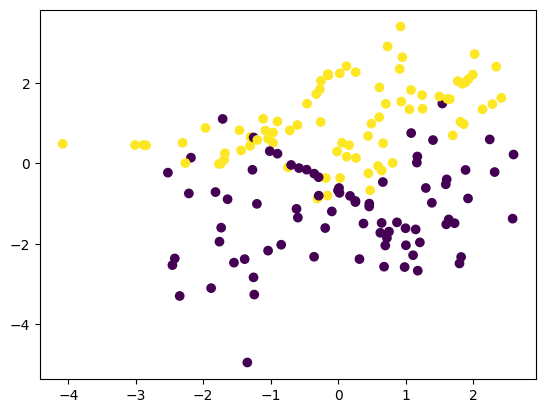

In [8]:
plt.scatter(
    features_orig[:,0], features_orig[:,1], c=labels_orig
)

## Warp data

In [9]:
if config['warp_functions'] == 'invented strongly nonlinear':
    def warp1(a):
        x = a[:,0]
        y = a[:,1]
        out1 = x*y
        out2 = x + np.exp(-y/10.)
        out3 = (np.log(x*x*y*y) + 10*x*x*y - x)/100.
        return np.stack((out1, out2, out3), axis=-1)

    def warp2(a):
        x = a[:,0]
        y = a[:,1]
        out1 = np.log(x*x*y*y) + 10*x*y*np.sin(x)
        out2 = y - 10*x*y
        out3 = x*y*np.tan(y)
        out4 = np.sin(x)-np.cos(y)
        return np.stack((out1, out2, out3, out4), axis=-1)

In [10]:
if config['warp_functions'] == 'inspired by swiss roll':
    def warp1(a):
        x = a[:,0]
        y = a[:,1]

        t = 1.5 * np.pi * (1 + 2 * x/x.max())
        out1 = t * np.cos(t)
        out2 = t * np.sin(t)
        out3 = 21 * np.power(y/y.max(), 2)

        return np.stack((out1/out1.max(), out2/out2.max(), out3/out3.max(), a[:,3]), axis=-1)

    def warp2(a):
        x = a[:,0]
        y = a[:,1]
        out1 = y - 5*x*y
        out2 = 10*y*y + a[:,3]
        return np.stack((out1/out1.max(), out2/out2.max(), a[:,2], a[:,3]), axis=-1)

In [11]:
if config['warp_functions'] == 'linear and scaling':
    def warp1(a):
        x = a[:,0]
        y = a[:,1]

        out1 = x
        out2 = y
        out3 = x+y

        return np.stack((out1, out2, out3), axis=-1)

    def warp2(a):
        x = a[:,0]
        y = a[:,1]
        out1 = 1e+4*x
        out2 = 1e+4*y
        out3 = 1e+4*(x - y)
        #out4 = 1e+4*(x + y)
        #return np.stack((out1, out2, out3, out4), axis=-1)
        return np.stack((out1, out2, out3), axis=-1)

In [12]:
if config['warp_functions'] == 'identity':
    def warp1(a):
        return a
    warp2 = warp1

In [13]:
if config['warp_functions'] == 'pure scaling':
    def warp1(a):
        return 1e-1*a
    def warp2(a):
        return 1e+1*a

In [14]:
if config['warp_functions'] == 'permute features in one client':
    rng = np.random.default_rng(seed=config['np_random_seed'])
    idx = rng.permutation(4)
    print(f"Permutation {idx}")
    def warp1(a):
        return a
    def warp2(a):
        return a[:, idx]

Permutation [1 3 0 2]


In [23]:
n_grid_points_per_latent_feature = 6  # number of grid points on each coordinate 
latent_feature_support = [features_orig.min()*0.5, features_orig.max()*2.]  # the min and max value of latent features

n_features = features_orig.shape[1]

# Generate random weights for each sample and feature
grid_points_one_coord = np.linspace(start=latent_feature_support[0],
                                    stop=latent_feature_support[1], 
                                    num=n_grid_points_per_latent_feature)
grid_points = np.array(np.meshgrid(*[grid_points_one_coord]*n_features)).T.reshape(-1,n_features)

In [24]:
def neg_sq_exp(x, c, sigma):
    return np.exp(-(x-c)**2/(2.*sigma**2))

In [25]:
def interpolator(x,c,sigma,w):
    return np.sum(
        [w[i] * neg_sq_exp(x,c[i],sigma) for i in range(len(c))]
        ,0)

In [26]:
def warp1(x):
    W = np.random.uniform(low=0.1, high=1., size=grid_points.shape )
    W = W/W.sum()
    sigma = 10.
    return interpolator(x, grid_points, sigma=sigma, w=W)

In [27]:
def warp2(x):
    W = np.random.uniform(low=0.1, high=1., size=grid_points.shape )
    W = W/W.sum()
    sigma = 0.5
    return interpolator(x, grid_points, sigma=sigma, w=W)

In [28]:
warping_fns = [
    warp1,
    warp2
]

## Split data among clients

In [29]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [30]:
def warp_dataset(features_orig, labels_orig, warping_fns, i_client, n_samples_per_client):
    features = warping_fns[i_client](features_orig[i_client*n_samples_per_client:(i_client+1)*n_samples_per_client,:])
    labels = labels_orig[i_client*n_samples_per_client:(i_client+1)*n_samples_per_client]
    return features, labels

In [31]:
def append_to_datasets(X_train, X_test, y_train, y_test):
    client_datasets_train.append(
        TensorDataset(
            torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(y_train)
        )
    )
    client_datasets_test.append(
        TensorDataset(
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_test)
        )
    )

In [32]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [33]:
if config['shuffle_features_among_clients']:
    features_orig, labels_orig = shuffle(features_orig, labels_orig)

In [34]:
n_clients = 2
n_samples_per_client = n_samples_per_class*n_classes//n_clients

client_datasets_train = []
client_datasets_test = []

for i_client in range(n_clients-1):
    features, labels = warp_dataset(features_orig, labels_orig, warping_fns, i_client, n_samples_per_client)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=config['sklearn_random_state']) 
    append_to_datasets(X_train, X_test, y_train, y_test)

i_client += 1
features, labels = warp_dataset(features_orig, labels_orig, warping_fns, i_client, n_samples_per_client)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=config['sklearn_random_state']) 
append_to_datasets(X_train, X_test, y_train, y_test)

## View dataset for client 1

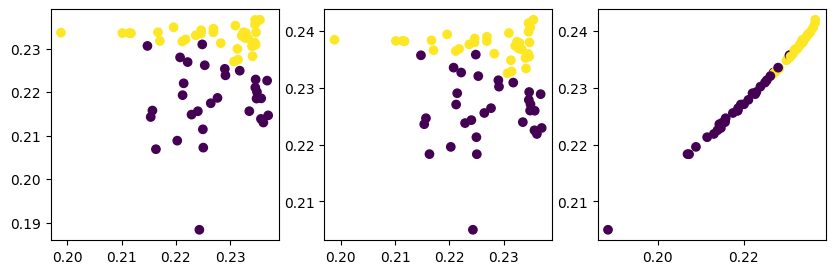

In [35]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
features_np = client_datasets_train[0].tensors[0].numpy()
labels_np = client_datasets_train[0].tensors[1].numpy()
ax[0].scatter(
    features_np[:,0], features_np[:,1], c=labels_np
)
ax[1].scatter(
    features_np[:,0], features_np[:,2], c=labels_np
)
ax[2].scatter(
    features_np[:,1], features_np[:,2], c=labels_np
)

## View dataset for client 2

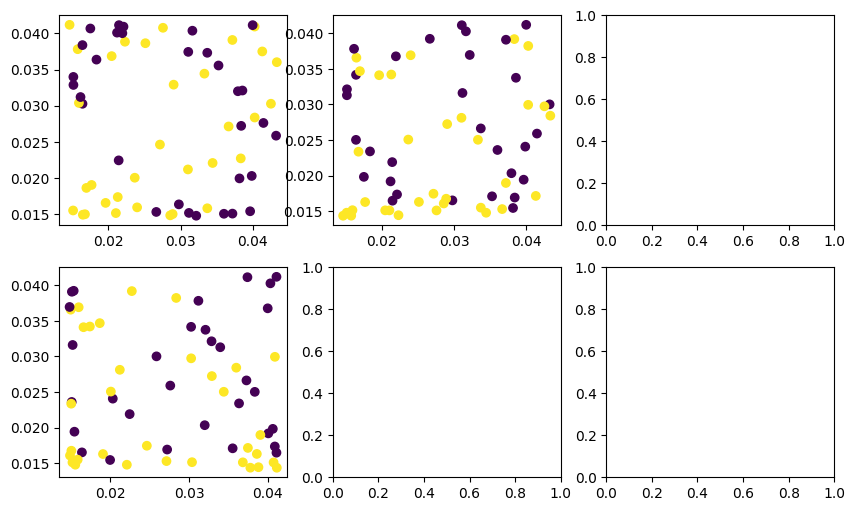

In [36]:
fig, ax = plt.subplots(2,3,figsize=(10,6))
features_np = client_datasets_train[1].tensors[0].numpy()
labels_np = client_datasets_train[1].tensors[1].numpy()
ax[0][0].scatter(
    features_np[:,0], features_np[:,1], c=labels_np
)
ax[0][1].scatter(
    features_np[:,0], features_np[:,2], c=labels_np
)
#ax[0][2].scatter(
#    features_np[:,0], features_np[:,3], c=labels_np
#)
ax[1][0].scatter(
    features_np[:,1], features_np[:,2], c=labels_np
)
#ax[1][1].scatter(
#    features_np[:,1], features_np[:,3], c=labels_np
#)
#ax[1][2].scatter(
#    features_np[:,2], features_np[:,3], c=labels_np
#)

## Definition of clients

In [117]:
from torch import nn
import torch.nn.functional as F

In [118]:
class Client(nn.Module):
    def __init__(self, encoder_model):
        super(Client, self).__init__()
        
        self.encoder_model = encoder_model
    
        self.latent_model = nn.Sequential(
            nn.Linear(config['latent_space_dim_1'],config['latent_space_dim_2']),
            nn.Linear(config['latent_space_dim_2'],2)
        )
        
        self.optimizer = torch.optim.SGD(self.parameters(), lr=config['lr'])

    def forward(self, inputs):
        outputs_encoder = self.encoder_model(inputs)
        outputs_latent = self.latent_model(outputs_encoder)
        #outputs_class = self.decoder_model(outputs_latent)
        #print(f"Outputs: {outputs_class}")
        return outputs_latent
    
    def get_latent_space(self, inputs):
        self.eval()
        outputs_encoder = self.encoder_model(inputs)
        return self.latent_model(outputs_encoder)

In [119]:
encoder_models = [
    nn.Sequential(
        nn.Linear(4,config['latent_space_dim_1']),
    ),
    nn.Sequential(
        nn.Linear(4,config['latent_space_dim_1'])
    )
]

In [120]:
clients = [Client(encoder_model=e) for e in encoder_models]

## DataLoaders

In [121]:
batch_size = config['batch_size']
shuffle_batches = True
loaders_train = [DataLoader(dataset=d, batch_size=batch_size, shuffle=shuffle_batches) for d in client_datasets_train]
loaders_test = [DataLoader(dataset=d, batch_size=batch_size, shuffle=shuffle_batches) for d in client_datasets_test]

## Training loop

In [122]:
tot_num_samples = np.sum([len(d) for d in client_datasets_train])

In [123]:
loss_fn = nn.BCEWithLogitsLoss()

In [124]:
# Do one "dummy" Federated Averaging to ensure latent models are the same
new_state_dict = dict()
weights = [len(d)/tot_num_samples for d in client_datasets_train]
for param_name, params in clients[0].latent_model.state_dict().items():
    avg_params = weights[0]*params.detach()
    for client_, weight_ in zip(clients[1:], weights[1:]):
        avg_params = avg_params + weight_*client_.latent_model.state_dict()[param_name].detach()
    new_state_dict[param_name] = avg_params
for client_ in clients:
    client_.latent_model.load_state_dict(new_state_dict)

print(f"After FedAVG {[client_.latent_model.state_dict()['0.weight'][0][:1] for client_ in clients]}")

After FedAVG [tensor([0.2335]), tensor([0.2335])]


In [125]:
init_model = clients[0].state_dict()

In [126]:
init_model.keys()

odict_keys(['encoder_model.0.weight', 'encoder_model.0.bias', 'latent_model.0.weight', 'latent_model.0.bias', 'latent_model.1.weight', 'latent_model.1.bias'])

In [127]:
from copy import deepcopy
from collections import OrderedDict
def translate_idea_model_state_dict_to_others(state_dict):
    names_map = OrderedDict()
    new_dict = OrderedDict()
    for key in state_dict.keys():
        if 'encoder_model' in key:
            names_map[key] = 'latent_model' + key[13:]
        else:
            layer_num = int(key.split('.')[1])
            names_map[key] = 'latent_model.' + str(layer_num + 1) + '.' + key.split('.')[-1]
    for old_name, new_name in names_map.items():
        new_dict[new_name] = state_dict[old_name].clone().detach()
    return new_dict

In [128]:
init_model_fedavg = translate_idea_model_state_dict_to_others(init_model)
init_model_local = translate_idea_model_state_dict_to_others(init_model)

In [129]:
for client in clients:
    client.load_state_dict(init_model)

In [130]:
do_fedavg = True

In [131]:
#num_epochs_per_round = 2
num_updates_per_round = config['num_updates_per_round']  #len(loaders_train[0])
num_rounds = config['num_rounds']
idea_train_losses = [[] for c in clients]
idea_val_losses = [[[] for d in loaders_test] for c in clients]

In [132]:
# first validation
with torch.no_grad():
    for i_client, client_ in enumerate(clients): 
        client_.eval()
        for i_loader, loader_ in enumerate(loaders_test):
            avg_loss = 0.
            loader_iter = iter(loader_)
            for data, label in loader_iter:
                prediction = client_.forward(data)
                target = torch.zeros_like(prediction, dtype=torch.float32)
                for i, label_idx in enumerate(label):
                    target[i,label_idx] = 1.
                loss = loss_fn(prediction, target)
                avg_loss += loss.detach()
            avg_loss /= len(loader_)
            print(f"Client {i_client} initial Validation Loss {avg_loss}")
            idea_val_losses[i_client][i_loader].append(avg_loss)


for round_ in range(1,num_rounds+1):
    #print(f"Before Training {[client_.latent_model.state_dict()['0.weight'][0][:1] for client_ in clients]}")
    
    for i_client, (client_, loader_) in enumerate(zip(clients, loaders_train)):
        client_.train()
        #for epoch_ in range(1,num_epochs_per_round+1):
        avg_loss = 0.
        loader_iter = iter(loader_)
        for iter_ in range(num_updates_per_round):
        #for data, label in loader_iter:
            try:
                data, label = next(loader_iter)
            except StopIteration:
                loader_iter = iter(loader_)
                data, label = next(loader_iter)
            client_.optimizer.zero_grad()
            #print(f":: data {data} :: label {label}")
            prediction = client_.forward(data)
            #print(f":: pred {prediction}")
            ## convert label to logits-like tensor
            target = torch.zeros_like(prediction, dtype=torch.float32)
            for i, label_idx in enumerate(label):
                target[i,label_idx] = 1.
            loss = loss_fn(prediction, target)
            #print(f":: target {target}")
            #print(f":: loss {loss}")
            loss.backward()
            client_.optimizer.step()
            avg_loss += loss.detach()
        avg_loss /= num_updates_per_round
        #print(f"Client {i_client} Epoch {epoch_} Average Loss {avg_loss}")
        idea_train_losses[i_client].append(avg_loss)
                
    #print(f"Before FedAVG {[client_.latent_model.state_dict()['0.weight'][0][:1] for client_ in clients]}")
            
    # Federated Averaging
    if do_fedavg:
        new_state_dict = dict()
        weights = [len(d)/tot_num_samples for d in client_datasets_train]
        for param_name, params in clients[0].latent_model.state_dict().items():
            avg_params = weights[0]*params.detach()
            for client_, weight_ in zip(clients[1:], weights[1:]):
                avg_params = avg_params + weight_*client_.latent_model.state_dict()[param_name].detach()
            new_state_dict[param_name] = avg_params
        for client_ in clients:
            client_.latent_model.load_state_dict(new_state_dict)
               
    #print(f"After FedAVG {[client_.latent_model.state_dict()['0.weight'][0][:1] for client_ in clients]}")
    
    with torch.no_grad():
        for i_client, client_ in enumerate(clients): 
            client_.eval()
            for i_loader, loader_ in enumerate(loaders_test):
                avg_loss = 0.
                loader_iter = iter(loader_)
                for data, label in loader_iter:
                    prediction = client_.forward(data)
                    target = torch.zeros_like(prediction, dtype=torch.float32)
                    for i, label_idx in enumerate(label):
                        target[i,label_idx] = 1.
                    loss = loss_fn(prediction, target)
                    avg_loss += loss.detach()
                avg_loss /= len(loader_)
                #print(f"Client {i_client} Round {round_} Validation Loss {avg_loss}")
                idea_val_losses[i_client][i_loader].append(avg_loss)

Client 0 initial Validation Loss 0.6915889978408813
Client 0 initial Validation Loss 0.6909125447273254
Client 1 initial Validation Loss 0.6915889978408813
Client 1 initial Validation Loss 0.6909125447273254


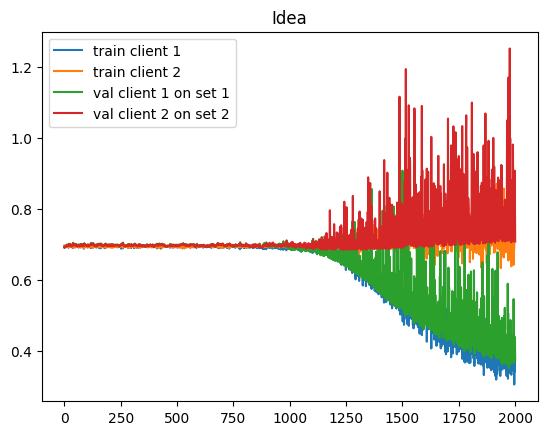

In [133]:
plt.plot(idea_train_losses[0], label='train client 1')
plt.plot(idea_train_losses[1], label='train client 2')
plt.plot(idea_val_losses[0][0], label='val client 1 on set 1')
#plt.plot(val_losses[0][1], label='val client 1 on set 2')
#plt.plot(val_losses[1][0], label='val client 2 on set 1')
plt.plot(idea_val_losses[1][1], label='val client 2 on set 2')
_ = plt.legend()
#plt.ylim([0.4, 1.0])
_ = plt.title('Idea')

In [134]:
class FedAVGClient(nn.Module):
    def __init__(self):
        super(FedAVGClient, self).__init__()
            
        self.latent_model = nn.Sequential(
            nn.Linear(4,config['latent_space_dim_1']),
            nn.Linear(config['latent_space_dim_1'],config['latent_space_dim_2']),
            nn.Linear(config['latent_space_dim_2'],2)
        )
        
        self.optimizer = torch.optim.SGD(self.parameters(), lr=config['lr'])

    def forward(self, inputs):
        outputs_latent = self.latent_model(inputs)
        return outputs_latent
    
    def get_latent_space(self, inputs):
        self.eval()
        outputs_encoder = self.encoder_model(inputs)
        return self.latent_model(outputs_encoder)

In [135]:
fedavg_clients = [FedAVGClient() for e in range(n_clients)]

In [136]:
for client in fedavg_clients:
    client.load_state_dict(init_model_fedavg)

In [137]:
# Do one "dummy" Federated Averaging to ensure latent models are the same
new_state_dict = dict()
weights = [len(d)/tot_num_samples for d in client_datasets_train]
for param_name, params in fedavg_clients[0].latent_model.state_dict().items():
    avg_params = weights[0]*params.detach()
    for client_, weight_ in zip(fedavg_clients[1:], weights[1:]):
        avg_params = avg_params + weight_*client_.latent_model.state_dict()[param_name].detach()
    new_state_dict[param_name] = avg_params
for client_ in fedavg_clients:
    client_.latent_model.load_state_dict(new_state_dict)

print(f"After FedAVG {[client_.latent_model.state_dict()['0.weight'][0][:1] for client_ in fedavg_clients]}")

After FedAVG [tensor([0.4095]), tensor([0.4095])]


In [138]:
fedavg_train_losses = [[] for c in fedavg_clients]
fedavg_val_losses = [[[] for d in loaders_test] for c in fedavg_clients]

# first validation
with torch.no_grad():
    for i_client, client_ in enumerate(fedavg_clients): 
        client_.eval()
        for i_loader, loader_ in enumerate(loaders_test):
            avg_loss = 0.
            loader_iter = iter(loader_)
            for data, label in loader_iter:
                prediction = client_.forward(data)
                target = torch.zeros_like(prediction, dtype=torch.float32)
                for i, label_idx in enumerate(label):
                    target[i,label_idx] = 1.
                loss = loss_fn(prediction, target)
                avg_loss += loss.detach()
            avg_loss /= len(loader_)
            print(f"Client {i_client} inital Validation Loss {avg_loss}")
            fedavg_val_losses[i_client][i_loader].append(avg_loss)


for round_ in range(1,num_rounds+1):
    #print(f"Before Training {[client_.latent_model.state_dict()['0.weight'][0][:1] for client_ in clients]}")
    
    for i_client, (client_, loader_) in enumerate(zip(fedavg_clients, loaders_train)):
        client_.train()
        #for epoch_ in range(1,num_epochs_per_round+1):
        avg_loss = 0.
        loader_iter = iter(loader_)
        for iter_ in range(num_updates_per_round):
        #for data, label in loader_iter:
            try:
                data, label = next(loader_iter)
            except StopIteration:
                loader_iter = iter(loader_)
                data, label = next(loader_iter)
            client_.optimizer.zero_grad()
            #print(f":: data {data} :: label {label}")
            prediction = client_.forward(data)
            #print(f":: pred {prediction}")
            ## convert label to logits-like tensor
            target = torch.zeros_like(prediction, dtype=torch.float32)
            for i, label_idx in enumerate(label):
                target[i,label_idx] = 1.
            loss = loss_fn(prediction, target)
            #print(f":: target {target}")
            #print(f":: loss {loss}")
            loss.backward()
            client_.optimizer.step()
            avg_loss += loss.detach()
        avg_loss /= num_updates_per_round
        #print(f"Client {i_client} Epoch {epoch_} Average Loss {avg_loss}")
        fedavg_train_losses[i_client].append(avg_loss)
                
    #print(f"Before FedAVG {[client_.latent_model.state_dict()['0.weight'][0][:1] for client_ in clients]}")
            
    # Federated Averaging
    if do_fedavg:
        new_state_dict = dict()
        weights = [len(d)/tot_num_samples for d in client_datasets_train]
        for param_name, params in fedavg_clients[0].latent_model.state_dict().items():
            avg_params = weights[0]*params.detach()
            for client_, weight_ in zip(fedavg_clients[1:], weights[1:]):
                avg_params = avg_params + weight_*client_.latent_model.state_dict()[param_name].detach()
            new_state_dict[param_name] = avg_params
        for client_ in fedavg_clients:
            client_.latent_model.load_state_dict(new_state_dict)
               
    #print(f"After FedAVG {[client_.latent_model.state_dict()['0.weight'][0][:1] for client_ in clients]}")
    
    with torch.no_grad():
        for i_client, client_ in enumerate(fedavg_clients): 
            client_.eval()
            for i_loader, loader_ in enumerate(loaders_test):
                avg_loss = 0.
                loader_iter = iter(loader_)
                for data, label in loader_iter:
                    prediction = client_.forward(data)
                    target = torch.zeros_like(prediction, dtype=torch.float32)
                    for i, label_idx in enumerate(label):
                        target[i,label_idx] = 1.
                    loss = loss_fn(prediction, target)
                    avg_loss += loss.detach()
                avg_loss /= len(loader_)
                #print(f"Client {i_client} Round {round_} Validation Loss {avg_loss}")
                fedavg_val_losses[i_client][i_loader].append(avg_loss)

Client 0 inital Validation Loss 0.6915889978408813
Client 0 inital Validation Loss 0.6909124851226807
Client 1 inital Validation Loss 0.6915889382362366
Client 1 inital Validation Loss 0.6909125447273254


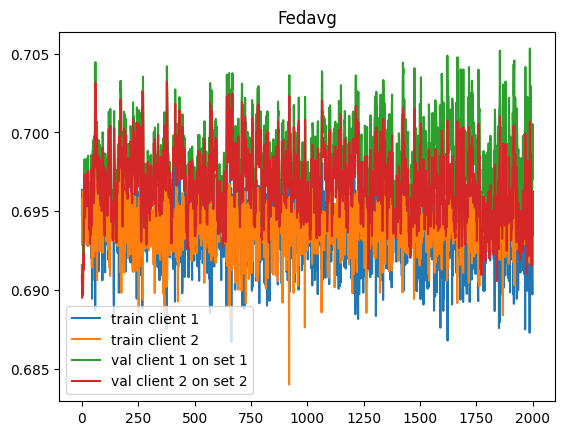

In [139]:
plt.plot(fedavg_train_losses[0], label='train client 1')
plt.plot(fedavg_train_losses[1], label='train client 2')
plt.plot(fedavg_val_losses[0][0], label='val client 1 on set 1')
#plt.plot(val_losses[0][1], label='val client 1 on set 2')
#plt.plot(val_losses[1][0], label='val client 2 on set 1')
plt.plot(fedavg_val_losses[1][1], label='val client 2 on set 2')
_ = plt.legend()
#plt.ylim([-0.1, 3.0])
_ = plt.title('Fedavg')

In [140]:
for client_ in clients:
    for name, param in client_.named_parameters():
        print(f"{name} :: {param.norm()}")
    print("  >>>>>>> ")
print("-----------------------------")
for client_ in fedavg_clients:
    for name, param in client_.named_parameters():
        print(f"{name} :: {param.norm()}")    
    print("  >>>>>>> ")

encoder_model.0.weight :: 22.600482940673828
encoder_model.0.bias :: 7.222837924957275
latent_model.0.weight :: 5.22988748550415
latent_model.0.bias :: 0.6991865038871765
latent_model.1.weight :: 1.685357928276062
latent_model.1.bias :: 0.07509876042604446
  >>>>>>> 
encoder_model.0.weight :: 8.855059623718262
encoder_model.0.bias :: 0.3158417344093323
latent_model.0.weight :: 5.22988748550415
latent_model.0.bias :: 0.6991865038871765
latent_model.1.weight :: 1.685357928276062
latent_model.1.bias :: 0.07509876042604446
  >>>>>>> 
-----------------------------
latent_model.0.weight :: 2.150128126144409
latent_model.0.bias :: 0.6741816401481628
latent_model.1.weight :: 1.3074568510055542
latent_model.1.bias :: 0.13049381971359253
latent_model.2.weight :: 0.8142430782318115
latent_model.2.bias :: 0.06002889201045036
  >>>>>>> 
latent_model.0.weight :: 2.150128126144409
latent_model.0.bias :: 0.6741816401481628
latent_model.1.weight :: 1.3074568510055542
latent_model.1.bias :: 0.1304938197

In [141]:
LocalClient = FedAVGClient

In [142]:
local_clients = [LocalClient() for e in range(n_clients)]

In [143]:
for client in local_clients:
    client.load_state_dict(init_model_local)

In [144]:
num_local_updates = num_updates_per_round*n_clients

local_train_losses = [[] for c in local_clients]
local_val_losses = [[[] for d in loaders_test] for c in local_clients]

# first validation
with torch.no_grad():
    for i_client, client_ in enumerate(local_clients): 
        client_.eval()
        for i_loader, loader_ in enumerate(loaders_test):
            avg_loss = 0.
            loader_iter = iter(loader_)
            for data, label in loader_iter:
                prediction = client_.forward(data)
                target = torch.zeros_like(prediction, dtype=torch.float32)
                for i, label_idx in enumerate(label):
                    target[i,label_idx] = 1.
                loss = loss_fn(prediction, target)
                avg_loss += loss.detach()
            avg_loss /= len(loader_)
            print(f"Client {i_client} initial Validation Loss {avg_loss}")
            local_val_losses[i_client][i_loader].append(avg_loss)


for round_ in range(1,num_rounds+1):
    #print(f"Before Training {[client_.latent_model.state_dict()['0.weight'][0][:1] for client_ in clients]}")
    
    for i_client, (client_, loader_) in enumerate(zip(local_clients, loaders_train)):
        client_.train()
        #for epoch_ in range(1,num_epochs_per_round+1):
        avg_loss = 0.
        loader_iter = iter(loader_)
        for iter_ in range(num_local_updates):
        #for data, label in loader_iter:
            try:
                data, label = next(loader_iter)
            except StopIteration:
                loader_iter = iter(loader_)
                data, label = next(loader_iter)
            client_.optimizer.zero_grad()
            #print(f":: data {data} :: label {label}")
            prediction = client_.forward(data)
            #print(f":: pred {prediction}")
            ## convert label to logits-like tensor
            target = torch.zeros_like(prediction, dtype=torch.float32)
            for i, label_idx in enumerate(label):
                target[i,label_idx] = 1.
            loss = loss_fn(prediction, target)
            #print(f":: target {target}")
            #print(f":: loss {loss}")
            loss.backward()
            client_.optimizer.step()
            avg_loss += loss.detach()
        avg_loss /= num_local_updates
        #print(f"Client {i_client} Epoch {epoch_} Average Loss {avg_loss}")
        local_train_losses[i_client].append(avg_loss)
                    
    with torch.no_grad():
        for i_client, client_ in enumerate(local_clients): 
            client_.eval()
            for i_loader, loader_ in enumerate(loaders_test):
                avg_loss = 0.
                loader_iter = iter(loader_)
                for data, label in loader_iter:
                    prediction = client_.forward(data)
                    target = torch.zeros_like(prediction, dtype=torch.float32)
                    for i, label_idx in enumerate(label):
                        target[i,label_idx] = 1.
                    loss = loss_fn(prediction, target)
                    avg_loss += loss.detach()
                avg_loss /= len(loader_)
                #print(f"Client {i_client} Round {round_} Validation Loss {avg_loss}")
                local_val_losses[i_client][i_loader].append(avg_loss)

Client 0 initial Validation Loss 0.6915889978408813
Client 0 initial Validation Loss 0.6909124851226807
Client 1 initial Validation Loss 0.6915889978408813
Client 1 initial Validation Loss 0.6909124851226807


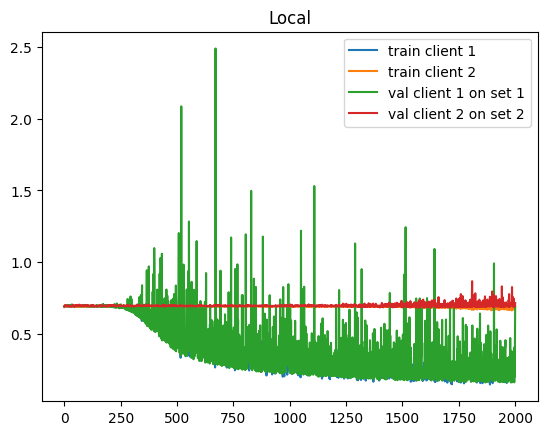

In [145]:
plt.plot(local_train_losses[0], label='train client 1')
plt.plot(local_train_losses[1], label='train client 2')
plt.plot(local_val_losses[0][0], label='val client 1 on set 1')
#plt.plot(val_losses[0][1], label='val client 1 on set 2')
#plt.plot(val_losses[1][0], label='val client 2 on set 1')
plt.plot(local_val_losses[1][1], label='val client 2 on set 2')
_ = plt.legend()
#plt.ylim([-0.1, 3.0])
_ = plt.title('Local')

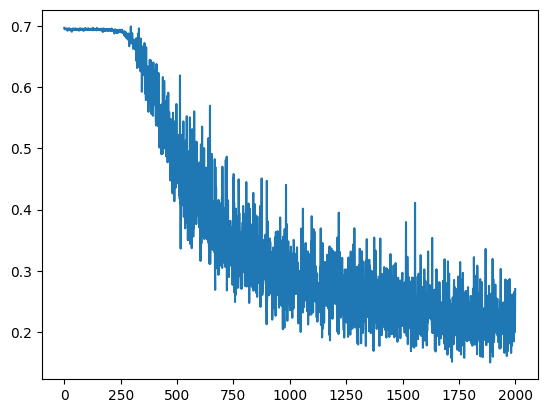

In [146]:
plt.plot(local_train_losses[0], label='train client 1')

In [147]:
for client_ in clients:
    for name, param in client_.named_parameters():
        print(f"{name} :: {param.norm()}")
    print("  >>>>>>> ")
print("-----------------------------")
for client_ in fedavg_clients:
    for name, param in client_.named_parameters():
        print(f"{name} :: {param.norm()}")    
    print("  >>>>>>> ")
print("-----------------------------")
for client_ in local_clients:
    for name, param in client_.named_parameters():
        print(f"{name} :: {param.norm()}")    
    print("  >>>>>>> ")

encoder_model.0.weight :: 22.600482940673828
encoder_model.0.bias :: 7.222837924957275
latent_model.0.weight :: 5.22988748550415
latent_model.0.bias :: 0.6991865038871765
latent_model.1.weight :: 1.685357928276062
latent_model.1.bias :: 0.07509876042604446
  >>>>>>> 
encoder_model.0.weight :: 8.855059623718262
encoder_model.0.bias :: 0.3158417344093323
latent_model.0.weight :: 5.22988748550415
latent_model.0.bias :: 0.6991865038871765
latent_model.1.weight :: 1.685357928276062
latent_model.1.bias :: 0.07509876042604446
  >>>>>>> 
-----------------------------
latent_model.0.weight :: 2.150128126144409
latent_model.0.bias :: 0.6741816401481628
latent_model.1.weight :: 1.3074568510055542
latent_model.1.bias :: 0.13049381971359253
latent_model.2.weight :: 0.8142430782318115
latent_model.2.bias :: 0.06002889201045036
  >>>>>>> 
latent_model.0.weight :: 2.150128126144409
latent_model.0.bias :: 0.6741816401481628
latent_model.1.weight :: 1.3074568510055542
latent_model.1.bias :: 0.1304938197

In [148]:
n_test_samples_per_class = config['n_test_samples_per_class']

In [149]:
if config['generation_method'] == 'manual':
    def generate_test(seed1, seed2=None):
        features_test = []
        labels_test = []

        for i in range(n_classes):
            features_test.append(
                np.random.multivariate_normal(mean=mus[i], 
                                              cov=covs[i],
                                              size=(n_test_samples_per_class,))
            )
            labels_test.append([i]*n_test_samples_per_class)

        features_test_orig = np.array(features_test).reshape(n_classes*n_test_samples_per_class, n_features)
        labels_test_orig = np.array(labels_test).reshape(n_classes*n_test_samples_per_class, 1).squeeze()
        return features_test_orig, labels_test_orig

In [150]:
if config['generation_method'] == 'make_classification single latent space':
    def generate_test(seed1, seed2=None):
        return make_classification(
            n_samples=n_test_samples_per_class*n_classes,
            n_informative=n_features,
            n_features=4,
            flip_y=0.,
            shuffle=False,
            random_state=seed1
        )

In [151]:
n_features = config['n_features']
if config['generation_method'] == 'make_classification multiple latent space':
    def generate_test(seed1, seed2=None):
        features_test_orig_1, labels_test_orig_1 = make_classification(
            n_samples=n_test_samples_per_class*n_classes//2,
            n_informative=n_features,
            n_features=4,
            flip_y=0.,
            shuffle=False,
            shift=-0.7,
            random_state=seed1
        )

        features_test_orig_2, labels_test_orig_2 = make_classification(
            n_samples=n_test_samples_per_class*n_classes//2,
            n_informative=n_features,
            n_features=4,
            flip_y=0.,
            shuffle=False,
            shift=+0.7,
            random_state=seed2
        )
        features_test_orig = np.concatenate((features_test_orig_1, features_test_orig_2))
        labels_test_orig = np.concatenate((labels_test_orig_1, labels_test_orig_2))
        return features_test_orig, labels_test_orig

In [152]:
def create_loaders_holdout(seed1, seed2=None):
    features_test_orig, labels_test_orig = generate_test(seed1, seed2)
    features_test_orig, labels_test_orig = shuffle(features_test_orig, labels_test_orig)
    n_test_samples_per_client = n_test_samples_per_class*n_classes//n_clients

    client_datasets_holdout = []
    for i_client in range(n_clients):
        features_test_, labels_test_ = warp_dataset(features_test_orig, labels_test_orig, warping_fns, i_client, n_test_samples_per_client)
        client_datasets_holdout.append(
            TensorDataset(
                torch.tensor(features_test_, dtype=torch.float32),
                torch.tensor(labels_test_)
            )
        )
    return [DataLoader(dataset=d, batch_size=batch_size, shuffle=shuffle_batches) for d in client_datasets_holdout]

In [153]:
n_valid = 30
idea_acc = [[] for i in range(n_clients)]
fedavg_acc = [[] for i in range(n_clients)]
local_acc = [[] for i in range(n_clients)]

for i in range(n_valid):
    
    seed1 = np.random.randint(99999999)
    seed2 = np.random.randint(99999999)
    
    loaders_holdout = create_loaders_holdout(seed1, seed2)
    
    with torch.no_grad():
        for i_client, (client_, loader_) in enumerate(zip(clients, loaders_holdout)): 
            client_.eval()
            n_accurate = 0
            n_samples = 0
            loader_iter = iter(loader_)
            for data, label in loader_iter:
                prediction = client_.forward(data)
                predicted_class = torch.argmax(prediction, dim=1)
                #print(f"{predicted_class} {label} {(predicted_class == label).sum()}")
                n_accurate += (predicted_class == label).sum()
                n_samples += predicted_class.shape[0]
            idea_acc[i_client].append(100.*n_accurate/n_samples)
            #print(f"Idea Client {i_client} Accuracy: {100.*n_accurate/n_samples:0.2f}%")

    with torch.no_grad():
        for i_client, (client_, loader_) in enumerate(zip(fedavg_clients, loaders_holdout)): 
            client_.eval()
            n_accurate = 0
            n_samples = 0
            loader_iter = iter(loader_)
            for data, label in loader_iter:
                prediction = client_.forward(data)
                predicted_class = torch.argmax(prediction, dim=1)
                #print(f"{predicted_class} {label} {(predicted_class == label).sum()}")
                n_accurate += (predicted_class == label).sum()
                n_samples += predicted_class.shape[0]
            fedavg_acc[i_client].append(100.*n_accurate/n_samples)
            #print(f"FedAVG Client {i_client} Accuracy: {100.*n_accurate/n_samples:0.2f}%")

    with torch.no_grad():
        for i_client, (client_, loader_) in enumerate(zip(local_clients, loaders_holdout)): 
            client_.eval()
            n_accurate = 0
            n_samples = 0
            loader_iter = iter(loader_)
            for data, label in loader_iter:
                prediction = client_.forward(data)
                predicted_class = torch.argmax(prediction, dim=1)
                #print(f"{predicted_class} {label} {(predicted_class == label).sum()}")
                n_accurate += (predicted_class == label).sum()
                n_samples += predicted_class.shape[0]
            local_acc[i_client].append(100.*n_accurate/n_samples)
            #print(f"Local Client {i_client} Accuracy: {100.*n_accurate/n_samples:0.2f}%")

for i_client in range(n_clients):
    print(f"Idea client {i_client} Mean accuracy: {np.mean(idea_acc[i_client]):0.2f}% std: {np.std(np.array(idea_acc[i_client])):0.2f}")
    print(f"Fedavg client {i_client} Mean accuracy: {np.mean(fedavg_acc[i_client]):0.2f}% std: {np.std(np.array(fedavg_acc[i_client])):0.2f}")
    print(f"Local client {i_client} Mean accuracy: {np.mean(local_acc[i_client]):0.2f}% std: {np.std(np.array(local_acc[i_client])):0.2f}")

Idea client 0 Mean accuracy: 69.47% std: 8.28
Fedavg client 0 Mean accuracy: 49.33% std: 5.52
Local client 0 Mean accuracy: 62.93% std: 9.26
Idea client 1 Mean accuracy: 49.27% std: 7.97
Fedavg client 1 Mean accuracy: 51.07% std: 5.46
Local client 1 Mean accuracy: 49.93% std: 6.27


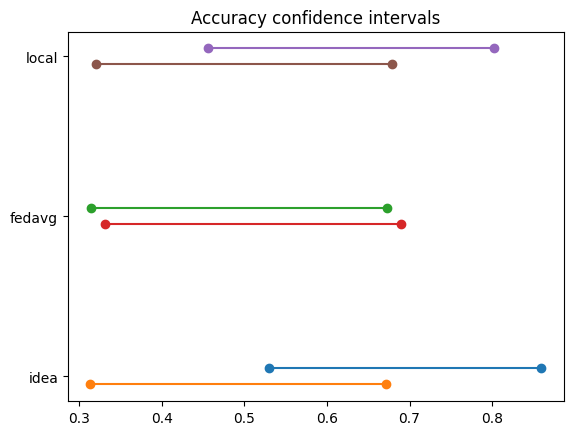

In [154]:
fig, ax = plt.subplots()

z = 1.96  # i.e. alpha=0.05 https://online.stat.psu.edu/stat100/lesson/9/9.1

method_names = ['idea', 'fedavg', 'local']
y_offsets = [+0.05, -0.05]

for i_method, method in enumerate([idea_acc, fedavg_acc, local_acc]):
    for i_client in range(n_clients):
        p = np.mean(method[i_client])/100.
        plusminus = z*np.sqrt(p*(1-p)/len(method[i_client]))
        ax.plot((p - plusminus, p+plusminus),(i_method+y_offsets[i_client], i_method+y_offsets[i_client]), 'o-')
        
ax.set_yticks([0,1,2])
_ = ax.set_yticklabels(method_names)
_ = ax.set_title('Accuracy confidence intervals')

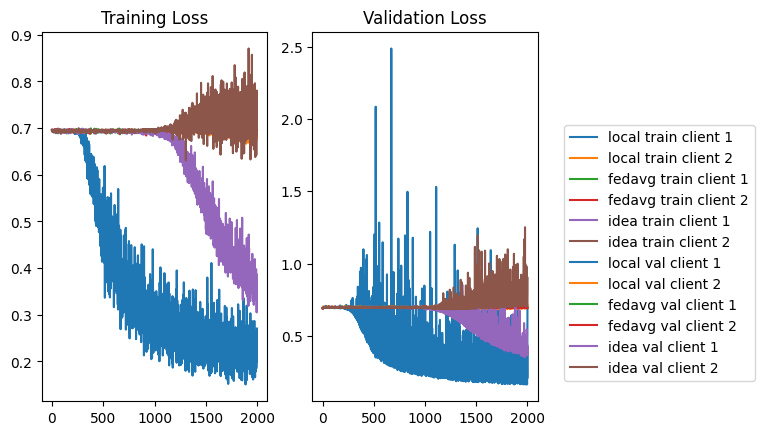

In [155]:
fig, ax = plt.subplots(1,2)
ax[0].plot(local_train_losses[0], label='local train client 1')
ax[0].plot(local_train_losses[1], label='local train client 2')
ax[0].plot(fedavg_train_losses[0], label='fedavg train client 1')
ax[0].plot(fedavg_train_losses[1], label='fedavg train client 2')
ax[0].plot(idea_train_losses[0], label='idea train client 1')
ax[0].plot(idea_train_losses[1], label='idea train client 2')

ax[1].plot(local_val_losses[0][0], label='local val client 1')
ax[1].plot(local_val_losses[1][1], label='local val client 2')
ax[1].plot(fedavg_val_losses[0][0], label='fedavg val client 1')
ax[1].plot(fedavg_val_losses[1][1], label='fedavg val client 2')
ax[1].plot(idea_val_losses[0][0], label='idea val client 1')
ax[1].plot(idea_val_losses[1][1], label='idea val client 2')

fig.legend(bbox_to_anchor=(1.25, .7))
_ = ax[0].set_title('Training Loss')
_ = ax[1].set_title('Validation Loss')

## Plot latent space

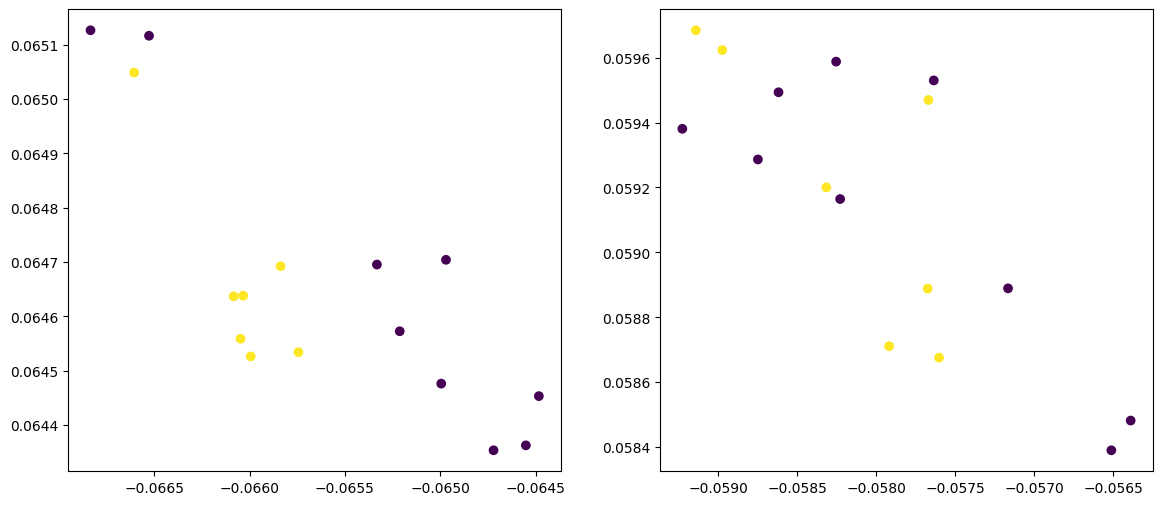

In [77]:
fig, axs = plt.subplots(1, n_clients, figsize=(14,6))
with torch.no_grad():
    for i, ax in enumerate(axs):
        client_ = clients[i]
        client_.eval()
        dataset = client_datasets_test[i]
        latent_space = []
        labels = []
        for idata in range(len(dataset)):
            data, label = dataset[idata]
            latent_space.append(client_.get_latent_space(data).detach().numpy())
            labels.append(label)
        latent_space = np.array(latent_space)
        ax.scatter(latent_space[:,0], latent_space[:,1], c=labels)

<BarContainer object of 4 artists>

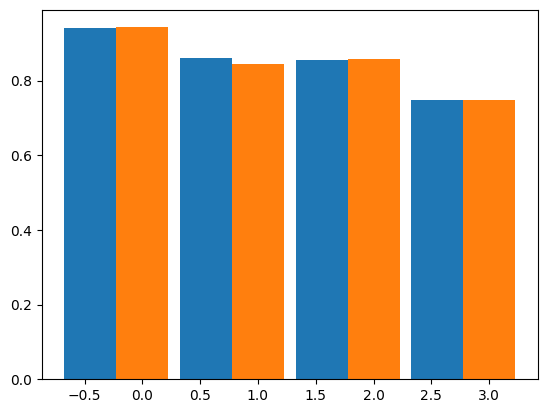

In [78]:
norms = []
for client_ in clients:
    for param in client_.encoder_model.parameters():
        #norms.append(torch.max(param.data, dim=0).values)
        norms.append(torch.norm(param.data, dim=0))
        break
        
fig, ax = plt.subplots()
ax.bar(np.arange(start=-0.45, stop=3.5, step=1.), norms[0], width=0.45)
ax.bar(np.arange(start=0., stop=4., step=1.), norms[1], width=0.45)